In [3]:
%%time
import os
import traceback
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import sqlalchemy
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import metrics
from sklearn.utils import resample
import xgboost as xgb
import seaborn as sns




user='hifld_summer'
pw='hifld_summer'
name='hifld_summer'
host='moria'
port=2023
engine = sqlalchemy.create_engine(
    f'postgresql://{user}:{pw}@{host}:{port}/{name}'
    )

CPU times: total: 0 ns
Wall time: 0 ns


In [4]:
%%time
"MODEL SET-UP"
"Loading in the data from the database"

sql ="""
select * from results.all_features_w_class
"""
df = pd.read_sql_query(sql, con=engine)

CPU times: total: 59 s
Wall time: 1min 5s


In [5]:
df.columns

Index(['uuid', 'parcel_lid', 'use_code_std_lps', 'use_code_std_desc_lps',
       'geom', 'build_id', 'prim_occ', 'new_sqmeters', 'perimeter',
       'vertex_count', 'length', 'width', 'long_side', 'short_side',
       'ls_ratio', 'pp_compactness', 'min_bounding_circle_area',
       'reock_compactness', 'sch_compactness', 'lon', 'lat',
       'points_in_polygon_buffers', 'ls_ratios_mean', 'ls_ratios_std',
       'ls_ratios_min', 'ls_ratios_max', 'area_mean', 'area_std', 'area_min',
       'area_max', 'mh_flag'],
      dtype='object')

In [6]:
%%time
"Dropping unnecessary columns (leaving only features and label) and setting index"

df = df.drop(columns=['geom', 'use_code_std_lps', 'use_code_std_desc_lps', 'parcel_lid', 'build_id', 'prim_occ'])

df.set_index('uuid', inplace=True)

CPU times: total: 703 ms
Wall time: 699 ms


In [7]:
df.head(2)

,new_sqmeters,perimeter,vertex_count,length,width,long_side,short_side,ls_ratio,pp_compactness,min_bounding_circle_area,...,points_in_polygon_buffers,ls_ratios_mean,ls_ratios_std,ls_ratios_min,ls_ratios_max,area_mean,area_std,area_min,area_max,mh_flag
uuid,,,,,,,,,,,,,,,,,,,,,
{41d5cadc-9dfb-4286-8c95-679ddc040416},505.712776,109.244544,6,38.737520,25.867066,38.73752,25.867066,1.497561,0.532493,1318.869211,...,14,1.184490,0.180276,1.011278,1.497561,195.826218,135.620522,42.908956,505.712776,0
{41d5cfec-707c-4d24-867e-a158aa450156},98.069987,57.020126,6,19.236482,19.350590,19.35059,19.236482,1.005932,0.379044,416.036078,...,5,1.587689,0.606463,1.005932,2.334468,165.185151,83.271834,98.069987,294.207192,0


In [8]:
"Oversample the majority class in order to reduce class imbalance"

df_class_0 = df[df['mh_flag'] == 0]
df_class_1 = df[df['mh_flag'] == 1]

# Oversample minority class
df_class_1_oversampled = resample(df_class_1,
                                  replace=True,             
                                  n_samples=len(df_class_0), 
                                  random_state=13)          

# Concatenate minority class and oversampled majority class
df_balanced = pd.concat([df_class_0, df_class_1_oversampled])

print('Balanced dataframe:', df_balanced['mh_flag'].value_counts())
print('Imbalanced dataframe:', df['mh_flag'].value_counts())

Balanced dataframe: mh_flag
0    2315962
1    2315962
Name: count, dtype: int64
Imbalanced dataframe: mh_flag
0    2315962
1     168074
Name: count, dtype: int64


In [9]:
%%time
"Seperating dataframe into x (features) and y (label)"

X = df_balanced.drop(columns=['mh_flag'], axis=1)
y = df_balanced['mh_flag']

CPU times: total: 328 ms
Wall time: 359 ms


In [10]:
%%time
"Checking for class imbalance"

df_balanced.mh_flag.value_counts(normalize=True)

CPU times: total: 62.5 ms
Wall time: 65.1 ms


mh_flag
0    0.5
1    0.5
Name: proportion, dtype: float64

In [11]:
%%time
"Splitting into training and testing datasets"

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

CPU times: total: 7.44 s
Wall time: 7.53 s


In [12]:
%%time
"Standardizing training set and applying the standardization to the training set"

sc = StandardScaler()
sc.fit(X_train)

X_train_scaled = sc.transform(X_train)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

CPU times: total: 1.62 s
Wall time: 1.63 s


In [13]:
%%time
"Saving the standard scaler"

dump(sc, 'my_standard_scaler.pkl')

CPU times: total: 31.2 ms
Wall time: 4 ms


['my_standard_scaler.pkl']

In [14]:
%%time
"Loading the standard scaler back"

same_scaler = load('my_standard_scaler.pkl')

CPU times: total: 0 ns
Wall time: 2 ms


In [15]:
%%time
"Applying the standardization to the testing set"


X_test_scaled = same_scaler.transform(X_test)

X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

CPU times: total: 312 ms
Wall time: 316 ms


In [16]:
"-----CLASSIFICATION MODELS---------------------------------------------------------------------------------------------------------------------------"

'-----CLASSIFICATION MODELS---------------------------------------------------------------------------------------------------------------------------'

In [19]:
%%time
"LINEAR CLASSIFER (BASELINE MODEL)"

base_lr = LogisticRegression(random_state = 42, max_iter=1000)

CPU times: total: 0 ns
Wall time: 0 ns


In [20]:
%%time
"Fitting linear classifier"

base_lr.fit(X_train, y_train)

CPU times: total: 2min 30s
Wall time: 38.5 s


LogisticRegression(max_iter=1000, random_state=42)

In [16]:
%%time
"Using the trained linear classifier to predict on the testing set"

base_lr_predict = base_lr.predict(X_test)

CPU times: total: 406 ms
Wall time: 217 ms


In [17]:
%%time
"Checking validity of the linear classifier's output"

base_lr_predict

CPU times: total: 0 ns
Wall time: 0 ns


array([0, 0, 1, ..., 1, 1, 0], dtype=int64)

In [18]:
%%time
"Creating a confusion matrix for the linear classifier"

lr_cmatrix = confusion_matrix(y_test, base_lr_predict)
print(lr_cmatrix)

[[475718 288205]
 [179584 585028]]
CPU times: total: 906 ms
Wall time: 882 ms


In [19]:
%%time
"Creating a classification report for the linear classifier"

print(classification_report(y_test, base_lr_predict))

              precision    recall  f1-score   support

           0       0.73      0.62      0.67    763923
           1       0.67      0.77      0.71    764612

    accuracy                           0.69   1528535
   macro avg       0.70      0.69      0.69   1528535
weighted avg       0.70      0.69      0.69   1528535

CPU times: total: 3.59 s
Wall time: 3.58 s


CPU times: total: 125 ms
Wall time: 113 ms


<Axes: >

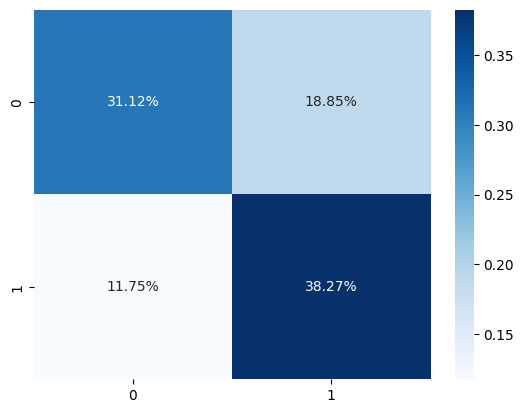

In [20]:
%%time
"Creating a heatmap for the linear classifier's confusion matrix"

sns.heatmap(lr_cmatrix/np.sum(lr_cmatrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [21]:
%%time
"DECISION TREE CLASSIFIER"

base_dt = DecisionTreeClassifier(random_state = 42)

CPU times: total: 0 ns
Wall time: 0 ns


In [22]:
%%time
"Fitting decision tree"

base_dt.fit(X_train, y_train)

CPU times: total: 3min 27s
Wall time: 3min 27s


DecisionTreeClassifier(random_state=42)

In [23]:
%%time
"Using the trained decision tree to predict on the testing set"

base_dt_predict = base_dt.predict(X_test)

CPU times: total: 1.22 s
Wall time: 1.22 s


In [24]:
%%time
"Checking validity of the decision tree's output"

base_dt_predict

CPU times: total: 0 ns
Wall time: 0 ns


array([1, 0, 1, ..., 1, 1, 0], dtype=int64)

In [25]:
%%time
"Creating a confusion matrix for the decision tree"

dt_cmatrix = confusion_matrix(y_test, base_dt_predict)
print(dt_cmatrix)

[[707628  56295]
 [    66 764546]]
CPU times: total: 578 ms
Wall time: 584 ms


In [26]:
%%time
"Creating a classification report for the decision tree"

print(classification_report(y_test, base_dt_predict))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96    763923
           1       0.93      1.00      0.96    764612

    accuracy                           0.96   1528535
   macro avg       0.97      0.96      0.96   1528535
weighted avg       0.97      0.96      0.96   1528535

CPU times: total: 3.69 s
Wall time: 3.72 s


CPU times: total: 141 ms
Wall time: 113 ms


<Axes: >

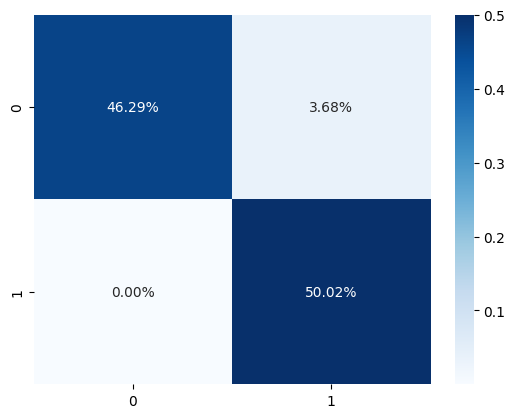

In [27]:
%%time
"Creating a heatmap for the decision tree's confusion matrix"

sns.heatmap(dt_cmatrix/np.sum(dt_cmatrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [28]:
%%time
"RANDOM FOREST CLASSIFIER"

base_rf = RandomForestClassifier(max_depth = 2, random_state = 42)

CPU times: total: 0 ns
Wall time: 0 ns


In [29]:
%%time
"Fitting random forest"

base_rf.fit(X_train, y_train)

CPU times: total: 7min 41s
Wall time: 7min 42s


RandomForestClassifier(max_depth=2, random_state=42)

In [30]:
%%time
"Using the trained random forest to predict on the testing set"

base_rf_predict = base_rf.predict(X_test)

CPU times: total: 8.69 s
Wall time: 8.7 s


In [31]:
%%time
"Checking validity of the random forest's output"

base_rf_predict

CPU times: total: 0 ns
Wall time: 0 ns


array([1, 0, 1, ..., 0, 1, 0], dtype=int64)

In [32]:
%%time
"Creating a confusion matrix for the random forest"

rf_cmatrix = confusion_matrix(y_test, base_rf_predict)
print(rf_cmatrix)

[[534485 229438]
 [171284 593328]]
CPU times: total: 547 ms
Wall time: 547 ms


In [33]:
%%time
"Creating a classification report for the random forest"

print(classification_report(y_test, base_rf_predict))

              precision    recall  f1-score   support

           0       0.76      0.70      0.73    763923
           1       0.72      0.78      0.75    764612

    accuracy                           0.74   1528535
   macro avg       0.74      0.74      0.74   1528535
weighted avg       0.74      0.74      0.74   1528535

CPU times: total: 3.69 s
Wall time: 3.69 s


CPU times: total: 93.8 ms
Wall time: 73.9 ms


<Axes: >

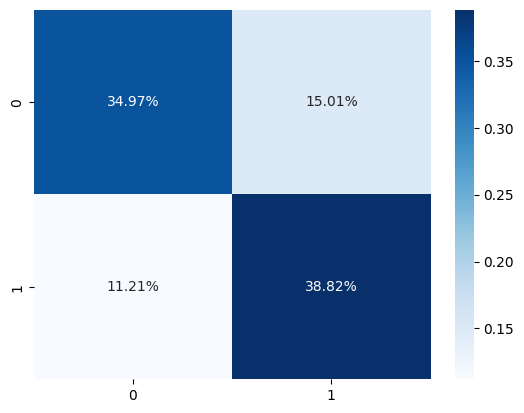

In [34]:
%%time
"Creating a heatmap for the random forest's confusion matrix"

sns.heatmap(rf_cmatrix/np.sum(rf_cmatrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [35]:
%%time
"XGBOOST CLASSIFIER"

base_xg = xgb.XGBClassifier(max_depth=2)

CPU times: total: 0 ns
Wall time: 0 ns


In [36]:
%%time
"Fitting random forest"

base_xg.fit(X_train, y_train)

CPU times: total: 1min 23s
Wall time: 13.4 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [37]:
%%time
"Using the trained random forest to predict on the testing set"

base_xg_predict = base_xg.predict(X_test)

CPU times: total: 2.55 s
Wall time: 390 ms


In [38]:
%%time
"Checking validity of the random forest's output"

base_xg_predict

CPU times: total: 0 ns
Wall time: 0 ns


array([1, 0, 1, ..., 1, 1, 0])

In [39]:
%%time
"Creating a confusion matrix for the random forest"

xg_cmatrix = confusion_matrix(y_test, base_xg_predict)
print(xg_cmatrix)

[[543470 220453]
 [127202 637410]]
CPU times: total: 469 ms
Wall time: 454 ms


In [40]:
%%time
"Creating a classification report for the random forest"

print(classification_report(y_test, base_xg_predict))

              precision    recall  f1-score   support

           0       0.81      0.71      0.76    763923
           1       0.74      0.83      0.79    764612

    accuracy                           0.77   1528535
   macro avg       0.78      0.77      0.77   1528535
weighted avg       0.78      0.77      0.77   1528535

CPU times: total: 3.41 s
Wall time: 3.42 s


CPU times: total: 62.5 ms
Wall time: 65.7 ms


<Axes: >

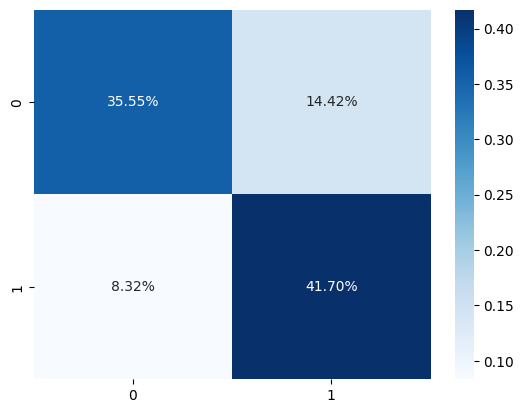

In [41]:
%%time
"Creating a heatmap for the random forest's confusion matrix"

sns.heatmap(xg_cmatrix/np.sum(xg_cmatrix), annot=True, 
            fmt='.2%', cmap='Blues')